<a href="https://colab.research.google.com/github/yjchen9596/tensorflow-for-deep-learning/blob/main/l08c08_forecasting_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an LSTM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

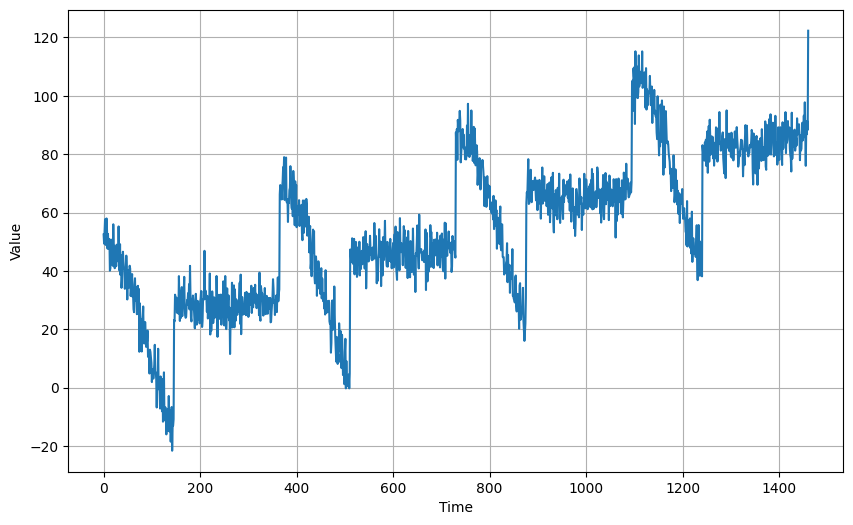

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# ────────────────────────────────────────────────────────────────────────────────
# 1) Dataset helper
# ────────────────────────────────────────────────────────────────────────────────
def sequential_window_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# ────────────────────────────────────────────────────────────────────────────────
# 2) Hyperparameters & data splits (assumes `series` already defined)
# ────────────────────────────────────────────────────────────────────────────────
split_time = 1000
x_train = series[:split_time]
x_valid = series[split_time:]

batch_size  = 1
window_size = 30

train_set = sequential_window_dataset(x_train, window_size, batch_size)
valid_set = sequential_window_dataset(x_valid, window_size, batch_size)

# ────────────────────────────────────────────────────────────────────────────────
# 3) Build a stateful LSTM model
# ────────────────────────────────────────────────────────────────────────────────
model = keras.models.Sequential([
    # Anchor batch_size & timesteps
    keras.layers.Input(batch_size=batch_size, shape=(window_size, 1)),

    # Stateful LSTM blocks
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.LSTM(100, stateful=True),

    # Forecast head
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

# ────────────────────────────────────────────────────────────────────────────────
# 4) Compile & callbacks
# ────────────────────────────────────────────────────────────────────────────────
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

class ResetStates(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, "reset_states"):
                layer.reset_states()

reset_states = ResetStates()
lr_schedule  = keras.callbacks.LearningRateScheduler(lambda e: 1e-8 * 10**(e/20))

# ────────────────────────────────────────────────────────────────────────────────
# 5) Train
# ────────────────────────────────────────────────────────────────────────────────
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=100,
    callbacks=[lr_schedule, reset_states]
)

Epoch 1/100
     28/Unknown 3s 10ms/step - loss: 7.9151 - mae: 8.4015

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 7.8634 - mae: 8.3496 - val_loss: 13.2166 - val_mae: 13.7101 - learning_rate: 1.0000e-08
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9010 - mae: 8.3768 - val_loss: 12.9044 - val_mae: 13.3993 - learning_rate: 1.1220e-08
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8121 - mae: 8.2937 - val_loss: 12.9374 - val_mae: 13.4318 - learning_rate: 1.2589e-08
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8503 - mae: 8.3253 - val_loss: 12.6329 - val_mae: 13.1275 - learning_rate: 1.4125e-08
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7631 - mae: 8.2432 - val_loss: 12.7225 - val_mae: 13.2170 - learning_rate: 1.5849e-08
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8437 - mae: 8.3181 - val_loss: 12.3375 - val_mae: 12.8312 - learning_rate: 1.7783e-08
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7263 - mae: 8.2061 - val_loss: 12.6141 - val_mae: 13.1080 - learni

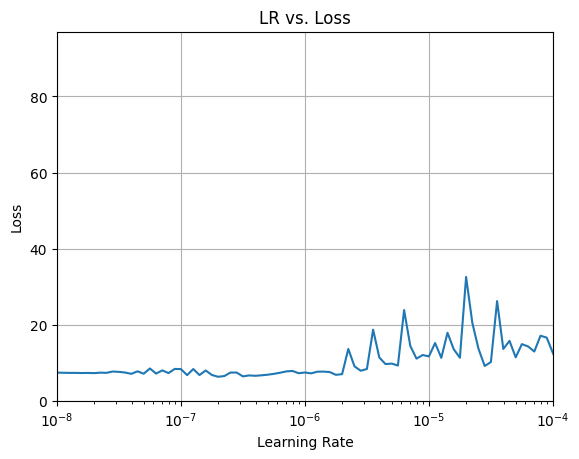

In [16]:
losses = history.history["loss"]
epochs = len(losses)
lrs    = 1e-8 * (10 ** (np.arange(epochs) / 20))

plt.semilogx(lrs, losses)
plt.axis([1e-8, 1e-4, 0, max(losses)])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("LR vs. Loss")
plt.grid(True)
plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# Learning-Rate Sweep Findings:
# • Sweet spot: 1e-7 → 1e-6 (loss ≈ 8–9)
# • LR <1e-7 → too slow (small updates → minimal loss decrease)
# • LR >1e-6 → unstable/divergent (overshoots minima → loss spikes)
# ────────────────────────────────────────────────────────────────────────────────

Epoch 1/500
     27/Unknown 1s 6ms/step - loss: 21.6259 - mae: 22.1221

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 20.4836 - mae: 20.9793 - val_loss: 11.5091 - val_mae: 12.0023
Epoch 2/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.1897 - mae: 16.6836

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 15.6487 - mae: 16.1421 - val_loss: 11.4618 - val_mae: 11.9503
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2143 - mae: 9.7050 - val_loss: 11.5511 - val_mae: 12.0409
Epoch 4/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.8525 - mae: 11.3459

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.5902 - mae: 11.0835 - val_loss: 10.2710 - val_mae: 10.7607
Epoch 5/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8677 - mae: 7.3499

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9135 - mae: 7.3958 - val_loss: 7.6464 - val_mae: 8.1351
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4016 - mae: 7.8899 - val_loss: 7.8825 - val_mae: 8.3695
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9694 - mae: 6.4463 - val_loss: 37.4966 - val_mae: 37.9939
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.8280 - mae: 9.3160 - val_loss: 8.4987 - val_mae: 8.9813
Epoch 9/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9023 - mae: 6.3797

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0160 - mae: 6.4938 - val_loss: 7.3333 - val_mae: 7.8200
Epoch 10/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8881 - mae: 6.3689

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0495 - mae: 6.5302 - val_loss: 6.9561 - val_mae: 7.4311
Epoch 11/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0874 - mae: 6.5686

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.3012 - mae: 6.7834 - val_loss: 6.7955 - val_mae: 7.2754
Epoch 12/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9967 - mae: 6.4781

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1287 - mae: 6.6103 - val_loss: 6.6144 - val_mae: 7.0946
Epoch 13/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9380 - mae: 6.4137

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.9701 - mae: 6.4462 - val_loss: 6.3843 - val_mae: 6.8663
Epoch 14/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8312 - mae: 6.3088

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.8999 - mae: 6.3780 - val_loss: 6.2461 - val_mae: 6.7290
Epoch 15/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7610 - mae: 6.2342

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8648 - mae: 6.3390 - val_loss: 6.1589 - val_mae: 6.6424
Epoch 16/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7010 - mae: 6.1765

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8326 - mae: 6.3089 - val_loss: 6.0385 - val_mae: 6.5227
Epoch 17/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6867 - mae: 6.1627

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7943 - mae: 6.2709 - val_loss: 5.8934 - val_mae: 6.3757
Epoch 18/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6864 - mae: 6.1626

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7577 - mae: 6.2343 - val_loss: 5.7633 - val_mae: 6.2439
Epoch 19/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6316 - mae: 6.1088

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7177 - mae: 6.1952 - val_loss: 5.6556 - val_mae: 6.1344
Epoch 20/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5950 - mae: 6.0724

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6803 - mae: 6.1580 - val_loss: 5.5656 - val_mae: 6.0455
Epoch 21/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5766 - mae: 6.0555

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6463 - mae: 6.1253 - val_loss: 5.4948 - val_mae: 5.9741
Epoch 22/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5355 - mae: 6.0156

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6185 - mae: 6.0985 - val_loss: 5.4312 - val_mae: 5.9119
Epoch 23/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4941 - mae: 5.9741

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5925 - mae: 6.0724 - val_loss: 5.3715 - val_mae: 5.8523
Epoch 24/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4854 - mae: 5.9649

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5665 - mae: 6.0461 - val_loss: 5.3203 - val_mae: 5.8005
Epoch 25/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4580 - mae: 5.9373

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5388 - mae: 6.0182 - val_loss: 5.2750 - val_mae: 5.7546
Epoch 26/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4124 - mae: 5.8919

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5093 - mae: 5.9889 - val_loss: 5.2336 - val_mae: 5.7141
Epoch 27/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4116 - mae: 5.8913

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4792 - mae: 5.9590 - val_loss: 5.1974 - val_mae: 5.6782
Epoch 28/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3671 - mae: 5.8467

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4491 - mae: 5.9288 - val_loss: 5.1645 - val_mae: 5.6452
Epoch 29/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3498 - mae: 5.8291

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4189 - mae: 5.8983 - val_loss: 5.1346 - val_mae: 5.6156
Epoch 30/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2887 - mae: 5.7677

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3889 - mae: 5.8681 - val_loss: 5.1074 - val_mae: 5.5885
Epoch 31/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3212 - mae: 5.8000

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3588 - mae: 5.8377 - val_loss: 5.0830 - val_mae: 5.5648
Epoch 32/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2561 - mae: 5.7346

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3284 - mae: 5.8071 - val_loss: 5.0602 - val_mae: 5.5427
Epoch 33/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2433 - mae: 5.7214

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.2982 - mae: 5.7766 - val_loss: 5.0382 - val_mae: 5.5209
Epoch 34/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2147 - mae: 5.6921

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.2705 - mae: 5.7482 - val_loss: 5.0179 - val_mae: 5.5005
Epoch 35/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2057 - mae: 5.6834

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.2459 - mae: 5.7238 - val_loss: 4.9991 - val_mae: 5.4816
Epoch 36/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1330 - mae: 5.6116

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2239 - mae: 5.7027 - val_loss: 4.9824 - val_mae: 5.4647
Epoch 37/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1278 - mae: 5.6069

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2040 - mae: 5.6832 - val_loss: 4.9671 - val_mae: 5.4490
Epoch 38/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0948 - mae: 5.5738

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1860 - mae: 5.6651 - val_loss: 4.9531 - val_mae: 5.4348
Epoch 39/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1132 - mae: 5.5918

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1701 - mae: 5.6488 - val_loss: 4.9405 - val_mae: 5.4220
Epoch 40/500
24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0087 - mae: 5.4865 

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1562 - mae: 5.6345 - val_loss: 4.9292 - val_mae: 5.4104
Epoch 41/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0549 - mae: 5.5327

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1438 - mae: 5.6219 - val_loss: 4.9188 - val_mae: 5.3996
Epoch 42/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1203 - mae: 5.5984

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1323 - mae: 5.6104 - val_loss: 4.9089 - val_mae: 5.3892
Epoch 43/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0844 - mae: 5.5624

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.1231 - mae: 5.6013 - val_loss: 4.8994 - val_mae: 5.3791
Epoch 44/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0427 - mae: 5.5201

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1150 - mae: 5.5926 - val_loss: 4.8890 - val_mae: 5.3680
Epoch 45/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0196 - mae: 5.4962

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1064 - mae: 5.5832 - val_loss: 4.8797 - val_mae: 5.3583
Epoch 46/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0111 - mae: 5.4880

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0982 - mae: 5.5752 - val_loss: 4.8717 - val_mae: 5.3501
Epoch 47/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0049 - mae: 5.4814

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0918 - mae: 5.5684 - val_loss: 4.8644 - val_mae: 5.3424
Epoch 48/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0004 - mae: 5.4781

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0867 - mae: 5.5643 - val_loss: 4.8579 - val_mae: 5.3358
Epoch 49/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9550 - mae: 5.4342

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.0829 - mae: 5.5617 - val_loss: 4.8515 - val_mae: 5.3293
Epoch 50/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9970 - mae: 5.4766

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0816 - mae: 5.5611 - val_loss: 4.8470 - val_mae: 5.3246
Epoch 51/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0126 - mae: 5.4922

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0820 - mae: 5.5615 - val_loss: 4.8431 - val_mae: 5.3203
Epoch 52/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0001 - mae: 5.4793

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0824 - mae: 5.5615 - val_loss: 4.8386 - val_mae: 5.3157
Epoch 53/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9615 - mae: 5.4399

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.0821 - mae: 5.5605 - val_loss: 4.8354 - val_mae: 5.3124
Epoch 54/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0024 - mae: 5.4808

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0818 - mae: 5.5604 - val_loss: 4.8321 - val_mae: 5.3092
Epoch 55/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9754 - mae: 5.4544

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.0803 - mae: 5.5595 - val_loss: 4.8274 - val_mae: 5.3048
Epoch 56/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0000 - mae: 5.4794

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0773 - mae: 5.5568 - val_loss: 4.8220 - val_mae: 5.2996
Epoch 57/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0408 - mae: 5.5204

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.0733 - mae: 5.5530 - val_loss: 4.8163 - val_mae: 5.2940
Epoch 58/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9931 - mae: 5.4728

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0694 - mae: 5.5492 - val_loss: 4.8106 - val_mae: 5.2882
Epoch 59/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9898 - mae: 5.4697

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0656 - mae: 5.5456 - val_loss: 4.8051 - val_mae: 5.2826
Epoch 60/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9993 - mae: 5.4793

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0619 - mae: 5.5420 - val_loss: 4.8000 - val_mae: 5.2775
Epoch 61/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9578 - mae: 5.4378

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0582 - mae: 5.5384 - val_loss: 4.7951 - val_mae: 5.2726
Epoch 62/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9653 - mae: 5.4455

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0543 - mae: 5.5346 - val_loss: 4.7902 - val_mae: 5.2675
Epoch 63/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9759 - mae: 5.4562

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0503 - mae: 5.5308 - val_loss: 4.7850 - val_mae: 5.2621
Epoch 64/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9721 - mae: 5.4525

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0464 - mae: 5.5269 - val_loss: 4.7800 - val_mae: 5.2569
Epoch 65/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9685 - mae: 5.4490

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.0425 - mae: 5.5231 - val_loss: 4.7754 - val_mae: 5.2519
Epoch 66/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9650 - mae: 5.4454

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0387 - mae: 5.5193 - val_loss: 4.7707 - val_mae: 5.2468
Epoch 67/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9475 - mae: 5.4279

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0351 - mae: 5.5156 - val_loss: 4.7661 - val_mae: 5.2418
Epoch 68/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9580 - mae: 5.4383

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0313 - mae: 5.5118 - val_loss: 4.7619 - val_mae: 5.2374
Epoch 69/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9301 - mae: 5.4103

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0275 - mae: 5.5079 - val_loss: 4.7582 - val_mae: 5.2334
Epoch 70/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9510 - mae: 5.4311

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0237 - mae: 5.5039 - val_loss: 4.7545 - val_mae: 5.2295
Epoch 71/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9474 - mae: 5.4274

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0199 - mae: 5.5000 - val_loss: 4.7507 - val_mae: 5.2254
Epoch 72/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9436 - mae: 5.4236

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0160 - mae: 5.4961 - val_loss: 4.7469 - val_mae: 5.2212
Epoch 73/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9398 - mae: 5.4198

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.0121 - mae: 5.4921 - val_loss: 4.7434 - val_mae: 5.2173
Epoch 74/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9361 - mae: 5.4159

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0083 - mae: 5.4882 - val_loss: 4.7400 - val_mae: 5.2137
Epoch 75/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9324 - mae: 5.4121

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0045 - mae: 5.4842 - val_loss: 4.7368 - val_mae: 5.2100
Epoch 76/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8953 - mae: 5.3752

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0006 - mae: 5.4804 - val_loss: 4.7335 - val_mae: 5.2065
Epoch 77/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9248 - mae: 5.4047

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9967 - mae: 5.4766 - val_loss: 4.7306 - val_mae: 5.2032
Epoch 78/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9741 - mae: 5.4541

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.9926 - mae: 5.4726 - val_loss: 4.7279 - val_mae: 5.2002
Epoch 79/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9168 - mae: 5.3968

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.9883 - mae: 5.4683 - val_loss: 4.7252 - val_mae: 5.1974
Epoch 80/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8991 - mae: 5.3791

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9839 - mae: 5.4639 - val_loss: 4.7226 - val_mae: 5.1946
Epoch 81/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9082 - mae: 5.3882

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9794 - mae: 5.4593 - val_loss: 4.7200 - val_mae: 5.1920
Epoch 82/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8711 - mae: 5.3512

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9747 - mae: 5.4546 - val_loss: 4.7173 - val_mae: 5.1893
Epoch 83/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8989 - mae: 5.3786

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9698 - mae: 5.4494 - val_loss: 4.7147 - val_mae: 5.1867
Epoch 84/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8939 - mae: 5.3735

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9647 - mae: 5.4441 - val_loss: 4.7123 - val_mae: 5.1843
Epoch 85/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8890 - mae: 5.3682

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9595 - mae: 5.4386 - val_loss: 4.7101 - val_mae: 5.1821
Epoch 86/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8837 - mae: 5.3626

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9540 - mae: 5.4328 - val_loss: 4.7080 - val_mae: 5.1801
Epoch 87/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8784 - mae: 5.3568

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9484 - mae: 5.4268 - val_loss: 4.7061 - val_mae: 5.1782
Epoch 88/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8846 - mae: 5.3628

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9428 - mae: 5.4209 - val_loss: 4.7039 - val_mae: 5.1761
Epoch 89/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8541 - mae: 5.3321

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.9367 - mae: 5.4145 - val_loss: 4.7017 - val_mae: 5.1739
Epoch 90/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8482 - mae: 5.3257

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.9303 - mae: 5.4079 - val_loss: 4.6997 - val_mae: 5.1720
Epoch 91/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8550 - mae: 5.3322

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.9240 - mae: 5.4012 - val_loss: 4.6978 - val_mae: 5.1702
Epoch 92/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8181 - mae: 5.2950

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9173 - mae: 5.3942 - val_loss: 4.6960 - val_mae: 5.1683
Epoch 93/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8419 - mae: 5.3183

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9102 - mae: 5.3867 - val_loss: 4.6942 - val_mae: 5.1666
Epoch 94/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8350 - mae: 5.3109

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9029 - mae: 5.3789 - val_loss: 4.6927 - val_mae: 5.1650
Epoch 95/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8284 - mae: 5.3037

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8958 - mae: 5.3713 - val_loss: 4.6917 - val_mae: 5.1640
Epoch 96/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8100 - mae: 5.2847

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8892 - mae: 5.3642 - val_loss: 4.6905 - val_mae: 5.1628
Epoch 97/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8160 - mae: 5.2902

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8825 - mae: 5.3570 - val_loss: 4.6895 - val_mae: 5.1619
Epoch 98/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8100 - mae: 5.2838

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8762 - mae: 5.3502 - val_loss: 4.6884 - val_mae: 5.1609
Epoch 99/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8615 - mae: 5.3349

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8698 - mae: 5.3433 - val_loss: 4.6876 - val_mae: 5.1602
Epoch 100/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8468 - mae: 5.3197

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.8638 - mae: 5.3369 - val_loss: 4.6866 - val_mae: 5.1592
Epoch 101/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8301 - mae: 5.3025

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8577 - mae: 5.3304 - val_loss: 4.6856 - val_mae: 5.1582
Epoch 102/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7861 - mae: 5.2583

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8513 - mae: 5.3239 - val_loss: 4.6842 - val_mae: 5.1569
Epoch 103/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7791 - mae: 5.2514

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8444 - mae: 5.3170 - val_loss: 4.6822 - val_mae: 5.1549
Epoch 104/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7599 - mae: 5.2322

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8374 - mae: 5.3100 - val_loss: 4.6791 - val_mae: 5.1519
Epoch 105/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7640 - mae: 5.2366

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8302 - mae: 5.3031 - val_loss: 4.6759 - val_mae: 5.1487
Epoch 106/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7448 - mae: 5.2179

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8238 - mae: 5.2971 - val_loss: 4.6717 - val_mae: 5.1444
Epoch 107/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7496 - mae: 5.2228

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8176 - mae: 5.2911 - val_loss: 4.6666 - val_mae: 5.1393
Epoch 108/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7427 - mae: 5.2161

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8118 - mae: 5.2855 - val_loss: 4.6611 - val_mae: 5.1340
Epoch 109/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7360 - mae: 5.2106

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8062 - mae: 5.2809 - val_loss: 4.6562 - val_mae: 5.1291
Epoch 110/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7306 - mae: 5.2059

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8017 - mae: 5.2771 - val_loss: 4.6512 - val_mae: 5.1241
Epoch 111/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6942 - mae: 5.1702

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7974 - mae: 5.2732 - val_loss: 4.6469 - val_mae: 5.1199
Epoch 112/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7212 - mae: 5.1974

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7938 - mae: 5.2699 - val_loss: 4.6428 - val_mae: 5.1161
Epoch 113/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7173 - mae: 5.1938

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7905 - mae: 5.2667 - val_loss: 4.6395 - val_mae: 5.1129
Epoch 114/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7142 - mae: 5.1907

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7877 - mae: 5.2641 - val_loss: 4.6362 - val_mae: 5.1099
Epoch 115/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6982 - mae: 5.1748

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7851 - mae: 5.2615 - val_loss: 4.6334 - val_mae: 5.1071
Epoch 116/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7088 - mae: 5.1854

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7827 - mae: 5.2592 - val_loss: 4.6305 - val_mae: 5.1043
Epoch 117/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7061 - mae: 5.1829

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7803 - mae: 5.2569 - val_loss: 4.6279 - val_mae: 5.1016
Epoch 118/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6905 - mae: 5.1674

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7781 - mae: 5.2547 - val_loss: 4.6252 - val_mae: 5.0989
Epoch 119/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7013 - mae: 5.1783

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7758 - mae: 5.2526 - val_loss: 4.6228 - val_mae: 5.0964
Epoch 120/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7638 - mae: 5.2407

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7737 - mae: 5.2505 - val_loss: 4.6202 - val_mae: 5.0937
Epoch 121/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7251 - mae: 5.2021

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7715 - mae: 5.2484 - val_loss: 4.6180 - val_mae: 5.0914
Epoch 122/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7066 - mae: 5.1837

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7695 - mae: 5.2465 - val_loss: 4.6158 - val_mae: 5.0891
Epoch 123/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7576 - mae: 5.2346

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7675 - mae: 5.2445 - val_loss: 4.6137 - val_mae: 5.0870
Epoch 124/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7558 - mae: 5.2328

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7657 - mae: 5.2427 - val_loss: 4.6115 - val_mae: 5.0848
Epoch 125/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7538 - mae: 5.2309

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7637 - mae: 5.2408 - val_loss: 4.6096 - val_mae: 5.0829
Epoch 126/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6735 - mae: 5.1509

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7620 - mae: 5.2391 - val_loss: 4.6076 - val_mae: 5.0810
Epoch 127/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6851 - mae: 5.1624

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7602 - mae: 5.2372 - val_loss: 4.6058 - val_mae: 5.0792
Epoch 128/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6834 - mae: 5.1607

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7585 - mae: 5.2356 - val_loss: 4.6039 - val_mae: 5.0775
Epoch 129/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6682 - mae: 5.1455

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7568 - mae: 5.2339 - val_loss: 4.6022 - val_mae: 5.0759
Epoch 130/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6800 - mae: 5.1572

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7552 - mae: 5.2322 - val_loss: 4.6004 - val_mae: 5.0743
Epoch 131/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7330 - mae: 5.2101

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7534 - mae: 5.2305 - val_loss: 4.5988 - val_mae: 5.0728
Epoch 132/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6766 - mae: 5.1539

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7519 - mae: 5.2289 - val_loss: 4.5972 - val_mae: 5.0713
Epoch 133/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6615 - mae: 5.1388

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7502 - mae: 5.2272 - val_loss: 4.5957 - val_mae: 5.0699
Epoch 134/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6498 - mae: 5.1271

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7488 - mae: 5.2258 - val_loss: 4.5942 - val_mae: 5.0685
Epoch 135/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6720 - mae: 5.1492

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7473 - mae: 5.2243 - val_loss: 4.5928 - val_mae: 5.0671
Epoch 136/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6706 - mae: 5.1478

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7459 - mae: 5.2229 - val_loss: 4.5914 - val_mae: 5.0658
Epoch 137/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6453 - mae: 5.1225

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7444 - mae: 5.2213 - val_loss: 4.5901 - val_mae: 5.0646
Epoch 138/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6439 - mae: 5.1210

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7430 - mae: 5.2198 - val_loss: 4.5888 - val_mae: 5.0634
Epoch 139/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6663 - mae: 5.1432

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7415 - mae: 5.2183 - val_loss: 4.5876 - val_mae: 5.0623
Epoch 140/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7198 - mae: 5.1965

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7402 - mae: 5.2169 - val_loss: 4.5864 - val_mae: 5.0611
Epoch 141/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6501 - mae: 5.1269

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7387 - mae: 5.2154 - val_loss: 4.5853 - val_mae: 5.0600
Epoch 142/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6488 - mae: 5.1256

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7374 - mae: 5.2140 - val_loss: 4.5842 - val_mae: 5.0590
Epoch 143/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6609 - mae: 5.1375

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7360 - mae: 5.2125 - val_loss: 4.5831 - val_mae: 5.0580
Epoch 144/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6596 - mae: 5.1362

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7346 - mae: 5.2111 - val_loss: 4.5821 - val_mae: 5.0570
Epoch 145/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6448 - mae: 5.1213

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7333 - mae: 5.2096 - val_loss: 4.5811 - val_mae: 5.0561
Epoch 146/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6570 - mae: 5.1334

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7319 - mae: 5.2083 - val_loss: 4.5801 - val_mae: 5.0551
Epoch 147/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7103 - mae: 5.1866

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7306 - mae: 5.2069 - val_loss: 4.5792 - val_mae: 5.0542
Epoch 148/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6544 - mae: 5.1308

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7292 - mae: 5.2055 - val_loss: 4.5783 - val_mae: 5.0533
Epoch 149/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6397 - mae: 5.1161

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7279 - mae: 5.2041 - val_loss: 4.5775 - val_mae: 5.0525
Epoch 150/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6385 - mae: 5.1149

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7266 - mae: 5.2028 - val_loss: 4.5766 - val_mae: 5.0516
Epoch 151/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6506 - mae: 5.1269

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7252 - mae: 5.2015 - val_loss: 4.5758 - val_mae: 5.0507
Epoch 152/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6492 - mae: 5.1256

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7238 - mae: 5.2001 - val_loss: 4.5749 - val_mae: 5.0499
Epoch 153/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6345 - mae: 5.1110

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7225 - mae: 5.1988 - val_loss: 4.5742 - val_mae: 5.0491
Epoch 154/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6332 - mae: 5.1097

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7211 - mae: 5.1974 - val_loss: 4.5734 - val_mae: 5.0483
Epoch 155/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6122 - mae: 5.0890

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7197 - mae: 5.1961 - val_loss: 4.5726 - val_mae: 5.0475
Epoch 156/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6438 - mae: 5.1205

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7183 - mae: 5.1947 - val_loss: 4.5718 - val_mae: 5.0467
Epoch 157/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6291 - mae: 5.1059

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7169 - mae: 5.1934 - val_loss: 4.5711 - val_mae: 5.0459
Epoch 158/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6278 - mae: 5.1046

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7156 - mae: 5.1921 - val_loss: 4.5704 - val_mae: 5.0452
Epoch 159/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6399 - mae: 5.1167

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7143 - mae: 5.1909 - val_loss: 4.5697 - val_mae: 5.0446
Epoch 160/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6150 - mae: 5.0920

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7129 - mae: 5.1895 - val_loss: 4.5690 - val_mae: 5.0438
Epoch 161/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6239 - mae: 5.1008

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7117 - mae: 5.1883 - val_loss: 4.5683 - val_mae: 5.0433
Epoch 162/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6359 - mae: 5.1128

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7103 - mae: 5.1870 - val_loss: 4.5676 - val_mae: 5.0425
Epoch 163/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6213 - mae: 5.0983

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7091 - mae: 5.1858 - val_loss: 4.5670 - val_mae: 5.0420
Epoch 164/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6334 - mae: 5.1103

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7078 - mae: 5.1844 - val_loss: 4.5663 - val_mae: 5.0413
Epoch 165/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6188 - mae: 5.0957

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7066 - mae: 5.1833 - val_loss: 4.5658 - val_mae: 5.0408
Epoch 166/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6852 - mae: 5.1620

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7052 - mae: 5.1820 - val_loss: 4.5651 - val_mae: 5.0401
Epoch 167/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6719 - mae: 5.1487

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.7041 - mae: 5.1808 - val_loss: 4.5645 - val_mae: 5.0396
Epoch 168/500
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6706 - mae: 5.1475

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7028 - mae: 5.1796 - val_loss: 4.5639 - val_mae: 5.0390
Epoch 169/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6272 - mae: 5.1041

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7017 - mae: 5.1784 - val_loss: 4.5633 - val_mae: 5.0384
Epoch 170/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6126 - mae: 5.0896

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7004 - mae: 5.1772 - val_loss: 4.5627 - val_mae: 5.0379
Epoch 171/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6248 - mae: 5.1017

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6993 - mae: 5.1760 - val_loss: 4.5622 - val_mae: 5.0375
Epoch 172/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6236 - mae: 5.1005

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6981 - mae: 5.1748 - val_loss: 4.5616 - val_mae: 5.0370
Epoch 173/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6224 - mae: 5.0993

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6969 - mae: 5.1736 - val_loss: 4.5611 - val_mae: 5.0366
Epoch 174/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6212 - mae: 5.0981

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6957 - mae: 5.1724 - val_loss: 4.5605 - val_mae: 5.0362
Epoch 175/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6200 - mae: 5.0968

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6945 - mae: 5.1712 - val_loss: 4.5601 - val_mae: 5.0358
Epoch 176/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6188 - mae: 5.0956

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6933 - mae: 5.1699 - val_loss: 4.5595 - val_mae: 5.0353
Epoch 177/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5845 - mae: 5.0615

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.6920 - mae: 5.1686 - val_loss: 4.5590 - val_mae: 5.0350
Epoch 178/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6163 - mae: 5.0930

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6907 - mae: 5.1672 - val_loss: 4.5584 - val_mae: 5.0345
Epoch 179/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6016 - mae: 5.0783

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6894 - mae: 5.1658 - val_loss: 4.5579 - val_mae: 5.0342
Epoch 180/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6004 - mae: 5.0770

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.6880 - mae: 5.1644 - val_loss: 4.5573 - val_mae: 5.0336
Epoch 181/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6125 - mae: 5.0891

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6867 - mae: 5.1631 - val_loss: 4.5568 - val_mae: 5.0332
Epoch 182/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5879 - mae: 5.0646

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6855 - mae: 5.1618 - val_loss: 4.5562 - val_mae: 5.0327
Epoch 183/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6102 - mae: 5.0868

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6843 - mae: 5.1606 - val_loss: 4.5556 - val_mae: 5.0322
Epoch 184/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5958 - mae: 5.0724

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6830 - mae: 5.1593 - val_loss: 4.5550 - val_mae: 5.0316
Epoch 185/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6079 - mae: 5.0844

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6818 - mae: 5.1581 - val_loss: 4.5545 - val_mae: 5.0312
Epoch 186/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6068 - mae: 5.0833

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6805 - mae: 5.1569 - val_loss: 4.5538 - val_mae: 5.0306
Epoch 187/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5924 - mae: 5.0689

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6793 - mae: 5.1556 - val_loss: 4.5534 - val_mae: 5.0303
Epoch 188/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6045 - mae: 5.0810

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6781 - mae: 5.1544 - val_loss: 4.5527 - val_mae: 5.0297
Epoch 189/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6034 - mae: 5.0798

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6769 - mae: 5.1532 - val_loss: 4.5523 - val_mae: 5.0293
Epoch 190/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5790 - mae: 5.0556

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6757 - mae: 5.1520 - val_loss: 4.5516 - val_mae: 5.0287
Epoch 191/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5879 - mae: 5.0644

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6746 - mae: 5.1508 - val_loss: 4.5512 - val_mae: 5.0284
Epoch 192/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5869 - mae: 5.0634

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6734 - mae: 5.1496 - val_loss: 4.5506 - val_mae: 5.0278
Epoch 193/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5990 - mae: 5.0753

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6723 - mae: 5.1485 - val_loss: 4.5501 - val_mae: 5.0275
Epoch 194/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5980 - mae: 5.0743

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6712 - mae: 5.1473 - val_loss: 4.5495 - val_mae: 5.0270
Epoch 195/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5968 - mae: 5.0731

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6700 - mae: 5.1462 - val_loss: 4.5491 - val_mae: 5.0267
Epoch 196/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5958 - mae: 5.0721

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6689 - mae: 5.1450 - val_loss: 4.5485 - val_mae: 5.0262
Epoch 197/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5815 - mae: 5.0578

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6677 - mae: 5.1438 - val_loss: 4.5481 - val_mae: 5.0259
Epoch 198/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5937 - mae: 5.0699

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6667 - mae: 5.1427 - val_loss: 4.5475 - val_mae: 5.0254
Epoch 199/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6208 - mae: 5.0969

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6656 - mae: 5.1416 - val_loss: 4.5471 - val_mae: 5.0251
Epoch 200/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6199 - mae: 5.0959

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6646 - mae: 5.1405 - val_loss: 4.5466 - val_mae: 5.0246
Epoch 201/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6541 - mae: 5.1300

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6635 - mae: 5.1394 - val_loss: 4.5462 - val_mae: 5.0244
Epoch 202/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6179 - mae: 5.0937

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6625 - mae: 5.1383 - val_loss: 4.5457 - val_mae: 5.0239
Epoch 203/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5563 - mae: 5.0323

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6615 - mae: 5.1372 - val_loss: 4.5454 - val_mae: 5.0237
Epoch 204/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5877 - mae: 5.0635

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6605 - mae: 5.1362 - val_loss: 4.5448 - val_mae: 5.0232
Epoch 205/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5867 - mae: 5.0624

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6595 - mae: 5.1352 - val_loss: 4.5445 - val_mae: 5.0230
Epoch 206/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5858 - mae: 5.0615

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6586 - mae: 5.1342 - val_loss: 4.5440 - val_mae: 5.0225
Epoch 207/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5525 - mae: 5.0284

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.6576 - mae: 5.1332 - val_loss: 4.5437 - val_mae: 5.0223
Epoch 208/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5708 - mae: 5.0466

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6567 - mae: 5.1323 - val_loss: 4.5432 - val_mae: 5.0219
Epoch 209/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5698 - mae: 5.0456

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6557 - mae: 5.1314 - val_loss: 4.5429 - val_mae: 5.0217
Epoch 210/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5821 - mae: 5.0579

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6548 - mae: 5.1305 - val_loss: 4.5424 - val_mae: 5.0212
Epoch 211/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5811 - mae: 5.0569

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6539 - mae: 5.1296 - val_loss: 4.5421 - val_mae: 5.0210
Epoch 212/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5672 - mae: 5.0431

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6530 - mae: 5.1288 - val_loss: 4.5416 - val_mae: 5.0205
Epoch 213/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5563 - mae: 5.0323

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6521 - mae: 5.1278 - val_loss: 4.5413 - val_mae: 5.0203
Epoch 214/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5655 - mae: 5.0415

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6513 - mae: 5.1270 - val_loss: 4.5408 - val_mae: 5.0199
Epoch 215/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5455 - mae: 5.0215

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6504 - mae: 5.1261 - val_loss: 4.5406 - val_mae: 5.0197
Epoch 216/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5770 - mae: 5.0529

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6496 - mae: 5.1254 - val_loss: 4.5400 - val_mae: 5.0192
Epoch 217/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5761 - mae: 5.0520

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6487 - mae: 5.1245 - val_loss: 4.5398 - val_mae: 5.0189
Epoch 218/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5624 - mae: 5.0383

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6480 - mae: 5.1237 - val_loss: 4.5392 - val_mae: 5.0184
Epoch 219/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5615 - mae: 5.0374

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6471 - mae: 5.1228 - val_loss: 4.5389 - val_mae: 5.0181
Epoch 220/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5739 - mae: 5.0498

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6463 - mae: 5.1221 - val_loss: 4.5383 - val_mae: 5.0175
Epoch 221/500
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6012 - mae: 5.0770

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.6455 - mae: 5.1213 - val_loss: 4.5379 - val_mae: 5.0172
Epoch 222/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6257 - mae: 5.1016

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6448 - mae: 5.1206 - val_loss: 4.5373 - val_mae: 5.0165
Epoch 223/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5718 - mae: 5.0477

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6440 - mae: 5.1198 - val_loss: 4.5369 - val_mae: 5.0162
Epoch 224/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5712 - mae: 5.0472

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6432 - mae: 5.1191 - val_loss: 4.5363 - val_mae: 5.0156
Epoch 225/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6332 - mae: 5.1091

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6424 - mae: 5.1183 - val_loss: 4.5359 - val_mae: 5.0152
Epoch 226/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5570 - mae: 5.0330

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6417 - mae: 5.1176 - val_loss: 4.5353 - val_mae: 5.0146
Epoch 227/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5562 - mae: 5.0322

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6409 - mae: 5.1168 - val_loss: 4.5350 - val_mae: 5.0143
Epoch 228/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5556 - mae: 5.0317

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6402 - mae: 5.1161 - val_loss: 4.5343 - val_mae: 5.0137
Epoch 229/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5678 - mae: 5.0437

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6394 - mae: 5.1152 - val_loss: 4.5341 - val_mae: 5.0134
Epoch 230/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5672 - mae: 5.0432

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.6387 - mae: 5.1146 - val_loss: 4.5335 - val_mae: 5.0128
Epoch 231/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5535 - mae: 5.0295

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.6378 - mae: 5.1137 - val_loss: 4.5333 - val_mae: 5.0126
Epoch 232/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5658 - mae: 5.0418

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6372 - mae: 5.1130 - val_loss: 4.5328 - val_mae: 5.0120
Epoch 233/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5520 - mae: 5.0279

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6363 - mae: 5.1120 - val_loss: 4.5326 - val_mae: 5.0118
Epoch 234/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6170 - mae: 5.0928

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6357 - mae: 5.1114 - val_loss: 4.5321 - val_mae: 5.0113
Epoch 235/500
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6161 - mae: 5.0918

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.6348 - mae: 5.1105 - val_loss: 4.5320 - val_mae: 5.0111
Epoch 236/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6252 - mae: 5.1008

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.6342 - mae: 5.1099 - val_loss: 4.5315 - val_mae: 5.0106
Epoch 237/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5493 - mae: 5.0251

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6333 - mae: 5.1090 - val_loss: 4.5314 - val_mae: 5.0105
Epoch 238/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5302 - mae: 5.0061

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6328 - mae: 5.1085 - val_loss: 4.5310 - val_mae: 5.0101
Epoch 239/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5480 - mae: 5.0239

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6320 - mae: 5.1077 - val_loss: 4.5309 - val_mae: 5.0100
Epoch 240/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5604 - mae: 5.0363

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6315 - mae: 5.1073 - val_loss: 4.5306 - val_mae: 5.0097
Epoch 241/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5468 - mae: 5.0227

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6307 - mae: 5.1065 - val_loss: 4.5304 - val_mae: 5.0095
Epoch 242/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5463 - mae: 5.0223

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6302 - mae: 5.1060 - val_loss: 4.5301 - val_mae: 5.0093
Epoch 243/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5455 - mae: 5.0215

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6294 - mae: 5.1052 - val_loss: 4.5300 - val_mae: 5.0091
Epoch 244/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5579 - mae: 5.0339

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6290 - mae: 5.1048 - val_loss: 4.5298 - val_mae: 5.0089
Epoch 245/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5571 - mae: 5.0331

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6282 - mae: 5.1040 - val_loss: 4.5296 - val_mae: 5.0087
Epoch 246/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5567 - mae: 5.0327

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6277 - mae: 5.1035 - val_loss: 4.5294 - val_mae: 5.0085
Epoch 247/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5333 - mae: 5.0094

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6269 - mae: 5.1027 - val_loss: 4.5293 - val_mae: 5.0083
Epoch 248/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5426 - mae: 5.0187

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6264 - mae: 5.1023 - val_loss: 4.5291 - val_mae: 5.0081
Epoch 249/500
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5418 - mae: 5.0179

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6255 - mae: 5.1014 - val_loss: 4.5290 - val_mae: 5.0078
Epoch 250/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5541 - mae: 5.0301

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6250 - mae: 5.1009 - val_loss: 4.5288 - val_mae: 5.0076
Epoch 251/500
26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5307 - mae: 5.0069

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6241 - mae: 5.1001 - val_loss: 4.5287 - val_mae: 5.0074
Epoch 252/500
28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5527 - mae: 5.0288

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6236 - mae: 5.0996 - val_loss: 4.5287 - val_mae: 5.0072
Epoch 253/500
25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5204 - mae: 4.9968

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6227 - mae: 5.0987 - val_loss: 4.5286 - val_mae: 5.0071
Epoch 254/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6131 - mae: 5.0892

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6221 - mae: 5.0982 - val_loss: 4.5286 - val_mae: 5.0070
Epoch 255/500
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5617 - mae: 5.0379

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6212 - mae: 5.0972 - val_loss: 4.5286 - val_mae: 5.0070
Epoch 256/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6207 - mae: 5.0967 - val_loss: 4.5286 - val_mae: 5.0070
Epoch 257/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6197 - mae: 5.0958 - val_loss: 4.5286 - val_mae: 5.0070
Epoch 258/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6192 - mae: 5.0953 - val_loss: 4.5287 - val_mae: 5.0072
Epoch 259/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6183 - mae: 5.0943 - val_loss: 4.5288 - val_mae: 5.0072
Epoch 260/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6177 - mae: 5.0938 - val_loss: 4.5291 - val_mae: 5.0074
Epoch 261/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6168 - mae: 5.0928 - val_loss: 4.5294 - val_mae: 5.0076
Epoch 262/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6162 - mae: 5.0922 - val_loss: 4.5298 - val_mae: 5.0080
Epoch 263/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss

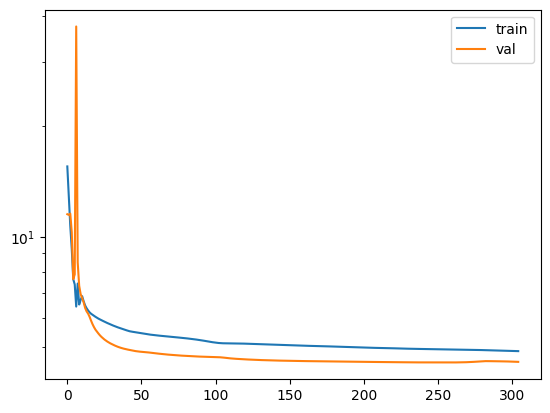

In [20]:
# ────────────────────────────────────────────────────────────────────────────────
# 0) Build the synthetic series (exactly as you did before)
# ────────────────────────────────────────────────────────────────────────────────
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Create the full series
time = np.arange(4 * 365 + 1, dtype=float)
baseline  = 10
slope     = 0.05
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, 365, amplitude)
series += white_noise(time, 5, seed=42)

# ────────────────────────────────────────────────────────────────────────────────
# 1) split train/validation
# ────────────────────────────────────────────────────────────────────────────────
split_time = 1000
x_train = series[:split_time]
x_valid = series[split_time:]

# ────────────────────────────────────────────────────────────────────────────────
# 2) windowed dataset builder
# ────────────────────────────────────────────────────────────────────────────────
def sequential_window_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)  # (time, 1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# ────────────────────────────────────────────────────────────────────────────────
# 3) Reset‐states callback
# ────────────────────────────────────────────────────────────────────────────────
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, "reset_states"):
                layer.reset_states()

# ────────────────────────────────────────────────────────────────────────────────
# 4) Prepare datasets & hyperparams
# ────────────────────────────────────────────────────────────────────────────────
window_size = 30
batch_size  = 1

train_set = sequential_window_dataset(x_train, window_size, batch_size)
valid_set = sequential_window_dataset(x_valid, window_size, batch_size)

# ────────────────────────────────────────────────────────────────────────────────
# 5) Build stateful LSTM model
# ────────────────────────────────────────────────────────────────────────────────
model = keras.models.Sequential([
    keras.layers.Input(batch_size=batch_size, shape=(window_size, 1)),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.LSTM(100, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(
    loss=keras.losses.Huber(),
    optimizer=keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9),
    metrics=["mae"]
)

# ────────────────────────────────────────────────────────────────────────────────
# 6) Train
# ────────────────────────────────────────────────────────────────────────────────
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=500,
    callbacks=[
      ResetStatesCallback(),
      keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True),
      keras.callbacks.EarlyStopping(patience=50)
    ]
)

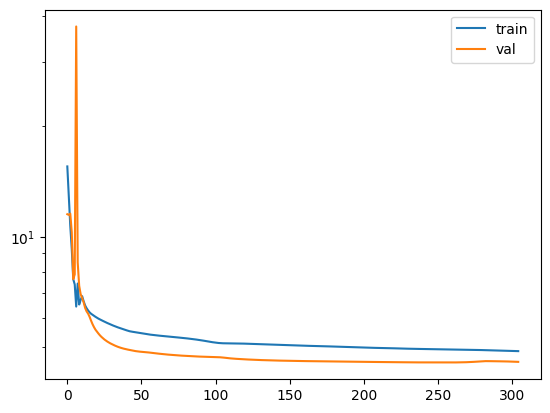

In [21]:
# ────────────────────────────────────────────────────────────────────────────────
# 7) Plot training & val loss
# ────────────────────────────────────────────────────────────────────────────────
plt.semilogy(history.history["loss"], label="train")
plt.semilogy(history.history["val_loss"], label="val")
plt.legend()
plt.show()

# Training/Validation Loss:
# - Both losses drop sharply in the first ~30 epochs (fast initial learning)
# - Validation loss closely follows training loss (minimal overfitting)
# - Losses plateau around 0.5–0.8 after ~100 epochs (diminishing returns)
# → Consider early stopping around 100–150 epochs

In [22]:
model = keras.models.load_model("my_checkpoint.h5")

In [24]:
# Predict once, get shape (1, 1)
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])  # → array shape (1,1)
last_pred    = rnn_forecast[0, 0]                                  # just one scalar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [1]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

NameError: name 'plt' is not defined

In [2]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

NameError: name 'keras' is not defined